# South Africa

S5P NO2: Original resolution: 7km x 7km. Improved resolution: 1km x 1km.

Predictors used at the moment:
* DEM

In [1]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re
import warnings
from collections import defaultdict

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt
import rasterio as rio
from shapely import geometry
from rasterstats import zonal_stats
import seaborn as sns

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GroupKFold
import statistics 

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   load_list_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)# South Africa

from utils_carles import polygrid, export_geotiff, percs_landuse, upscale_mean_tiff, extract_points_from_raster

In [2]:
DATA_DIR = Path('training_dataset_south_africa')
AOIS = ['South_Africa']

In [3]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

In [4]:
# CHANGE THIS VALUE to True IF PRE-PROCESSING NEEDS TO BE DONE
preproc = True

## Pre-processing (training data)

Prepare CAMS data. I do not do any temporal adjustment because we're using DEM for now. EPSG=4326.

In [285]:
# Read S5P NO2
s5p_train_dir = DATA_DIR/AOIS[0]/'sentinel5P'
#s5p_products = ['NO2','UV_AEROSOL_INDEX']
s5p_products = sorted(os.listdir(s5p_train_dir))

s5p_eops = [load_tiffs(s5p_train_dir/s5p_p, (FeatureType.DATA, s5p_p), offset=OFFSET) 
           for s5p_p in s5p_products]

s5p_eop = EOPatch(data={'NO2': s5p_eops[0].data['NO2'], 
                        'UV_AEROSOL_INDEX': s5p_eops[1].data['UV_AEROSOL_INDEX']},
                  meta_info={'Names_NO2':s5p_eops[0].meta_info['Names'],
                             'Names_UV_AEROSOL':s5p_eops[1].meta_info['Names']},
                  timestamp=s5p_eops[0].timestamp,
                  bbox=s5p_eops[0].bbox)
del s5p_eops
s5p_eop


EOPatch(
  data: {
    NO2: numpy.ndarray(shape=(100, 70, 77, 2), dtype=float32)
    UV_AEROSOL_INDEX: numpy.ndarray(shape=(85, 71, 77, 2), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_NO2: ['S5P_NO2__RPRO_L2_day2141_T10.tif', ..., 'S5P_NO2__RPRO_L2_day2232_T12.tif'], length=100
    Names_UV_AEROSOL: ['S5P_AER_AI_OFFL_L2_day2168_T10.tif', ..., 'S5P_AER_AI_OFFL_L2_day2232_T12.tif'], length=85
  }
  bbox: BBox(((26.677331470947365, -27.758826442871097), (31.51909147094736, -23.35722644287111)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 10, 0), ..., datetime.datetime(1900, 5, 12, 12, 0)], length=100
)

In [286]:
## Filtet unvalid pixels 

## Set no valid data to np.nan

s5p_eop.data['NO2'][s5p_eop.data['NO2'] == NO_DATA_VALUE] = np.nan
s5p_eop.data['UV_AEROSOL_INDEX'][s5p_eop.data['UV_AEROSOL_INDEX'] == NO_DATA_VALUE] = np.nan


## Use Qa band to reduce noisy observations
min_q_a = 50

for s5pp in s5p_products:
    s5p_eop.data[s5pp][..., 0][s5p_eop.data[s5pp][..., 1] <= min_q_a] = np.nan

In [177]:
### Extract NO2 bands after filitering them 

## location of exported tiff
filtered_s5p_products = ['filtered_NO2', 'filtered_UV_AEROSOL_INDEX']

filtered_S5P_location = str(DATA_DIR/AOIS[0])+'/filtered_sentinel5P'
if not os.path.isdir(filtered_S5P_location):
    os.makedirs(filtered_S5P_location)
    for i in filtered_s5p_products:
        os.mkdir(filtered_S5P_location + '/' + i)


        
## Task to add the filtered NO2 band 
add_NO2 = (FeatureType.DATA_TIMELESS, 'NO2')
add_s5p_NO2 = AddFeature(add_NO2)

## Task to export the merged tiff (mean of daily measurments)
export_tiff = ExportToTiff((FeatureType.DATA_TIMELESS, 'NO2'))


t,x,y,b = s5p_eop.data['NO2'].shape

for index in range(t):
    NO2_array = s5p_eop.data['NO2'][index][...,0]
    # add dimension
    NO2_array= np.expand_dims(NO2_array, axis=-1)
    
    ## execute the add task
    add_s5p_NO2.execute(s5p_eop,NO2_array)
    
    ## tiff name (filtered NO2)
    tiffname = s5p_eop.meta_info['Names_NO2'][index]
    
    ## export the tiff (filtered NO2)
    export_tiff.execute(s5p_eop, filename=str(filtered_S5P_location)+'/filtered_NO2'+'/'+tiffname)
    

In [5]:
## lOAD FILTERED NO2
s5p_train_dir = DATA_DIR/AOIS[0]/'filtered_sentinel5P'

s5p_eop = load_tiffs(s5p_train_dir/'filtered_NO2', (FeatureType.DATA, 'NO2'), offset=OFFSET) 
           

In [12]:
s5p_eop

EOPatch(
  data: {
    NO2: numpy.ndarray(shape=(100, 70, 77, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names: ['S5P_NO2__RPRO_L2_day2141_T10.tif', ..., 'S5P_NO2__RPRO_L2_day2232_T12.tif'], length=100
  }
  bbox: BBox(((26.677331470947365, -27.758826442871097), (31.51909147094736, -23.35722644287111)), crs=CRS('4326'))
  timestamp: [datetime.datetime(1900, 2, 10, 10, 0), ..., datetime.datetime(1900, 5, 12, 12, 0)], length=100
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


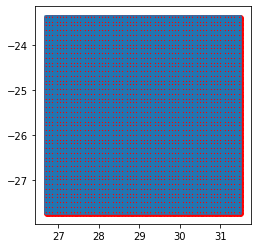

In [20]:
# Create rectangular grid for pixels corresponding to NO2
bounds = list(s5p_eop.bbox)
xres = (bounds[2]-bounds[0])/s5p_eop.data["NO2"].shape[1]
yres = (bounds[3]-bounds[1])/s5p_eop.data["NO2"].shape[2]
bounds = geometry.box(bounds[0], bounds[1], bounds[2], bounds[3])
bounds = gpd.GeoDataFrame({"id":1,"geometry":[bounds]}, crs="EPSG:4326")
s5p_grid = polygrid(bounds, xres,yres, 4326)
s5p_centroids = gpd.GeoDataFrame(geometry= s5p_grid.centroid)
p = s5p_grid.boundary.plot()
s5p_centroids.plot(ax=p, color='red')
plt.show()

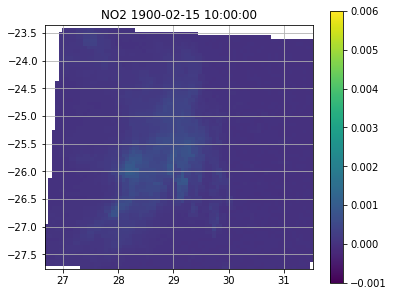

In [15]:
# Draw a sample
fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=s5p_eop, 
                 feature=(FeatureType.DATA, 'NO2'),
                 time_idx=5, 
                 vmin=-0.001, vmax=0.006)
fig.colorbar(fh, ax=ax);

Prepare DEM data at 1km resolution to make computations easier. EPSG=4326

In [186]:
# Resampling DEM to 1 Km with the same bounding box of NO2 to make it manageable. Use custom function to use mean.
if preproc:
    # Get resampling dimensions
    target_size = bbox_to_dimensions(s5p_eop.bbox, 1000)

    # Sampling files to 40 km using bilinear interpolaiton
    path_in = Path(str(DATA_DIR/AOIS[0])+'/DEM/COP_DSM_south_africa_GLO-30.tif')
    #path_out = str(DATA_DIR/AOIS[0])+'/DEM/NO2_DEM_1km.tif'
    filename = 'NO2_DEM_1km.tif'
    upscale_mean_tiff(path_in, filename, target_size)

Now compute mean DEM per CAMS pixel

In [16]:
# Read resampled DEM at 1 km
if preproc:
    no_data_value = 128
    dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
    dem_train_eop = load_tiffs(datapath=dem_train_dir,
                              feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                              filename='NO2_DEM_1km.tif',
                            no_data_value=no_data_value)
    
    ## FILTER NO VALID DATA BEFORE STARTING
    dem_train_eop.data_timeless['DEM'][dem_train_eop.data_timeless['DEM'] == no_data_value] = np.nan
    
    # Perform zonal statistics - mean altitude per CAMS pixel
    src = rio.open(str(dem_train_dir) + '/NO2_DEM_1km.tif')
    affine = src.transform
    array = dem_train_eop.data_timeless['DEM']
    array = array[:, :, 0] # Remove one dimension
    dem_grid = s5p_grid
    zstats = zonal_stats(dem_grid, array, affine=affine, stats="mean", nodata=np.nan)
    vals = []
    for index, value in enumerate(zstats):
        vals.append(value['mean'])
    dem_grid['elevation'] = vals

In [17]:
# Now we can rasterize
if preproc:
    minx, miny, maxx, maxy = s5p_grid.geometry.total_bounds
    sizey = round((maxy-miny)/yres)
    sizex = round((maxx-minx)/xres)
    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
    shapes = ((geom, value) for geom, value in zip(dem_grid.geometry, dem_grid['elevation']))
    dem = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    dem
    export_geotiff(str(dem_train_dir) + '/DEM_NO2_train.tif', dem, transform, 4326)

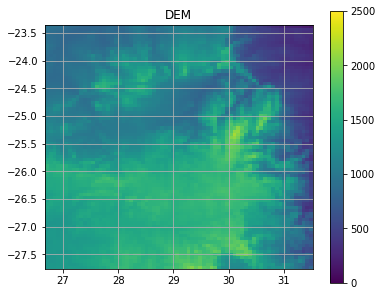

In [21]:
# Read and visualize
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                           filename='DEM_NO2.tif')

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=dem_train_eop, 
                 feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                 time_idx=None, 
                 vmin=0, vmax=2500)
fig.colorbar(fh, ax=ax);

### Prepare ERA5 to match NO2 grid

In [22]:
## Select the temporal data of ERA5, the same of CAMS
era5_train_dir = DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))

hours = ['h10','h11','h12']
era5_products = ['relative_humidity', 'specific_rain_water_content', 'wind_u', 'wind_v']
files_name = []
for era5_p in era5_products:
    era5_product_paths = []
    for hour in hours:
        era5_product_path = glob.glob(str(era5_train_dir) +'/' +era5_p + '/' +  f'*{hour}.tif')[0:2208]
        era5_product_paths = era5_product_paths + era5_product_path
        filenames = [path.replace(str(era5_train_dir) + f'/{era5_p}/','') for path in era5_product_paths]
        
    files_name.append(filenames)
#files_name

In [36]:
# Resampling the selected ERA5 to 1 Km with the same bounding box of NO2 to make it manageable. Use billinar resampling.

## Location 
resampled_era5_no2_location = str(DATA_DIR/AOIS[0])+'/resampled_era5_NO2'
if not os.path.isdir(resampled_era5_no2_location):
    os.makedirs(resampled_era5_no2_location)
    for i in era5_products:
        os.mkdir(resampled_era5_no2_location + '/' + i) 


if preproc:
    # Get resampling dimensions
    target_size = bbox_to_dimensions(s5p_eop.bbox, 1000)

    for index, era5_p in enumerate(era5_products):
        filenames = files_name[index]
        tiffs = filenames
        for tiff in tiffs:
            for j in glob.glob(str(era5_train_dir) + '/' + era5_p +'/' +tiff):
                path_in = j
                path_out = re.sub('era5', 'resampled_era5_NO2', path_in)
                upscale_tiff(path_in, path_out, target_size)
            


In [37]:
## Load ERA5
resampled_era5_no2_location = Path(resampled_era5_no2_location)
# Load data
era5_eops = []
for file_names, era5_p in [(files_name[0], 'relative_humidity'),(files_name[1], 'specific_rain_water_content'),(files_name[2], 'wind_u'),(files_name[3], 'wind_v')]:
    era5_eop = load_list_tiffs(resampled_era5_no2_location/era5_p, 
                               (FeatureType.DATA,era5_p), 
                                offset=OFFSET,
                                filename = file_names,
                                image_dtype=np.float32,
                                data_source='era5')
    era5_eops.append(era5_eop)



# Merge into one EOPS
era5_eop = EOPatch(data={'relative_humidity': era5_eops[0].data['relative_humidity'], 
                         'specific_rain_water_content': era5_eops[1].data['specific_rain_water_content'],
                        'wind_u': era5_eops[2].data['wind_u'],
                        'wind_v': era5_eops[3].data['wind_v']},
                   meta_info={'Names_relative_humidity': era5_eops[0].meta_info['Names'],
                              'Names_specific_rain_water_content': era5_eops[1].meta_info['Names'],
                             'Names_wind_u': era5_eops[2].meta_info['Names'],
                             'Names_wind_v': era5_eops[3].meta_info['Names']},
                     timestamp=era5_eops[0].timestamp,
                     bbox=era5_eops[0].bbox)
del era5_eops
era5_eop

EOPatch(
  data: {
    relative_humidity: numpy.ndarray(shape=(276, 494, 480, 1), dtype=float32)
    specific_rain_water_content: numpy.ndarray(shape=(276, 494, 480, 1), dtype=float32)
    wind_u: numpy.ndarray(shape=(276, 494, 480, 1), dtype=float32)
    wind_v: numpy.ndarray(shape=(276, 494, 480, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_relative_humidity: ['ERA5_rh_day2141_h10.tif', ..., 'ERA5_rh_day2232_h12.tif'], length=276
    Names_specific_rain_water_content: ['ERA5_srwc_day2141_h10.tif', ..., 'ERA5_srwc_day2232_h12.tif'], length=276
    Names_wind_u: ['ERA5_u_day2141_h10.tif', ..., 'ERA5_u_day2232_h12.tif'], length=276
    Names_wind_v: ['ERA5_v_day2141_h10.tif', ..., 'ERA5_v_day2232_h12.tif'], length=276
  }
  bbox: BBox(((26.875, -27.815000534057617), (31.375, -23.565000534057617)), crs=CRS('4326'))
  timestamp: [date

In [38]:
## Filter NO VALID DATA OF ERA5
NO_DATA_VALUE = -32767

era5_eop.data['relative_humidity'][era5_eop.data['relative_humidity'] == NO_DATA_VALUE] = np.nan
era5_eop.data['specific_rain_water_content'][era5_eop.data['specific_rain_water_content'] == NO_DATA_VALUE] = np.nan
era5_eop.data['wind_u'][era5_eop.data['wind_u'] == NO_DATA_VALUE] = np.nan
era5_eop.data['wind_v'][era5_eop.data['wind_v'] == NO_DATA_VALUE] = np.nan

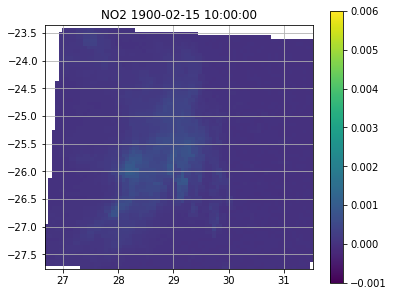

In [39]:
# Draw a sample
fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=s5p_eop, 
                 feature=(FeatureType.DATA, 'NO2'),
                 time_idx=5, 
                 vmin=-0.001, vmax=0.006)
fig.colorbar(fh, ax=ax);

In [40]:

# Perform zonal statistics - ERA5 products per CAMS pixel
# Rastrize the new CAMS zonal stats and save them on disk

era5_location=  str(DATA_DIR/AOIS[0])+'/resampled_era5_NO2'

## location of exported tiff (ERA5 matching CAMS grid)
era5_train_no2_location = str(DATA_DIR/AOIS[0])+'/rasterize_era5_no2'
if not os.path.isdir(era5_train_no2_location):
    os.makedirs(era5_train_no2_location)
    for i in era5_products:
        os.mkdir(era5_train_no2_location + '/' + i)
        
for index, era5p in enumerate(era5_products):
    tiffs = sorted(files_name[index])
    i=0
    for tiff in tiffs:
        for era5_path in glob.glob(str(era5_location) + '/' + era5p + '/' +  tiff):
            src = rio.open(era5_path)
            affine = src.transform
            array = era5_eop.data[era5p][i]
            array = array[:, :, 0]
            era5_grid = s5p_grid
            era5_stats = zonal_stats(era5_grid, array, affine=affine, stats="mean", nodata=np.nan)

            vals = []
            for index, value in enumerate(era5_stats):
                vals.append(value['mean'])

            era5_grid[era5p] = vals

            # rasterize
            minx, miny, maxx, maxy = s5p_grid.geometry.total_bounds
            sizey = round((maxy-miny)/yres)
            sizex = round((maxx-minx)/xres)

            transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
            shapes = ((geom, value) for geom, value in zip(era5_grid.geometry, era5_grid[era5p]))
            era5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
            tiffname = era5_eop.meta_info['Names_'+ era5p][i]
            export_geotiff(str(era5_train_no2_location) + '/' +era5p + '/'+ tiffname, era5, transform, 4326)
            
            i+=1

del era5_eop

In [41]:
## Read rastraized ERA5 


# Load data
ras_era5_eops = [load_tiffs(Path(era5_train_no2_location)/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]



# Merge into one EOPS
ras_era5_eop = EOPatch(data={'relative_humidity': ras_era5_eops[0].data['relative_humidity'], 
                              'specific_rain_water_content': ras_era5_eops[1].data['specific_rain_water_content'],
                              'wind_u': ras_era5_eops[2].data['wind_u'],
                              'wind_v': ras_era5_eops[3].data['wind_v']},
                        meta_info={'Names_relative_humidity': ras_era5_eops[0].meta_info['Names'],
                                   'Names_specific_rain_water_content':ras_era5_eops[1].meta_info['Names'],
                                   'Names_wind_u': ras_era5_eops[2].meta_info['Names'],
                                   'Names_wind_v': ras_era5_eops[3].meta_info['Names']},
                        timestamp= ras_era5_eops[0].timestamp,
                        bbox= ras_era5_eops[0].bbox)

del ras_era5_eops
ras_era5_eop

EOPatch(
  data: {
    relative_humidity: numpy.ndarray(shape=(276, 77, 70, 1), dtype=float32)
    specific_rain_water_content: numpy.ndarray(shape=(276, 77, 70, 1), dtype=float32)
    wind_u: numpy.ndarray(shape=(276, 77, 70, 1), dtype=float32)
    wind_v: numpy.ndarray(shape=(276, 77, 70, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_relative_humidity: ['ERA5_rh_day2141_h10.tif', ..., 'ERA5_rh_day2232_h12.tif'], length=276
    Names_specific_rain_water_content: ['ERA5_srwc_day2141_h10.tif', ..., 'ERA5_srwc_day2232_h12.tif'], length=276
    Names_wind_u: ['ERA5_u_day2141_h10.tif', ..., 'ERA5_u_day2232_h12.tif'], length=276
    Names_wind_v: ['ERA5_v_day2141_h10.tif', ..., 'ERA5_v_day2232_h12.tif'], length=276
  }
  bbox: BBox(((26.677331470947365, -27.758826442871097), (31.51909147094745, -23.357226442871085)), crs=CRS('4326'))
  t

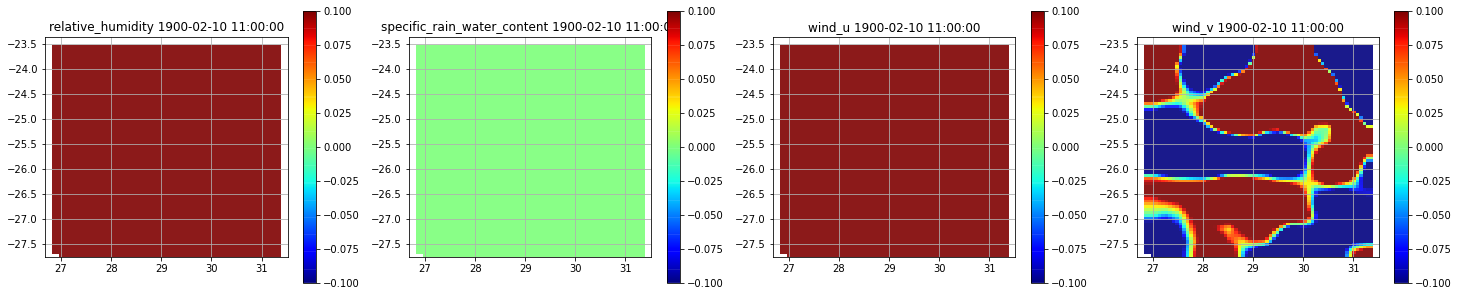

In [42]:
## plot rastraized ERA5

fig, axs = plt.subplots(figsize=(25, 5), ncols=4)

time_idx = 1

normalisations = [dict(vmin=np.min(ras_era5_eop.data[era5_p]), 
                       vmax=np.max(ras_era5_eop.data[era5_p])) 
                  for era5_p in era5_products]

for nn, (fname, norm) in enumerate(zip(era5_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=ras_era5_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

# Data merging

Now that everything is in the same format, we need to create our training datasets to start modelling.

In [43]:
# Extract DEM
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
if preproc:
    raster_path = [(str(dem_train_dir) + '/DEM_NO2.tif')]
    dem_df = extract_points_from_raster(s5p_centroids, raster_path, 'DEM')
    dem_df = pd.concat(dem_df)
    dem_df = dem_df.dropna()
    dem_df = dem_df.drop('raster', 1)
    

In [51]:
# Extract NO2

s5p_train_dir = DATA_DIR/AOIS[0]/'filtered_sentinel5P'

s5p_paths = glob.glob(str(s5p_train_dir) + '/filtered_NO2/*.tif')[0:150]
s5p_df = extract_points_from_raster(s5p_centroids, s5p_paths, 'NO2')
s5p_df = pd.concat(s5p_df)
s5p_df = s5p_df.dropna()


In [50]:
## Extract ERA5 

era5_train_no2_location = str(DATA_DIR/AOIS[0])+'/rasterize_era5_no2'

## We can put this function in the utility file
def extract_era5(era5_p,no2_centroids,path):
    era5_paths = glob.glob(str(path) + '/'+ era5_p +'/*.tif')[0:736]
    era5_df = extract_points_from_raster(no2_centroids, era5_paths, era5_p)
    era5_df = pd.concat(era5_df)
    era5_df = era5_df.dropna()
    return era5_df

relative_humidity_df = extract_era5('relative_humidity', s5p_centroids, era5_train_no2_location)
specific_rain_water_content_df = extract_era5('specific_rain_water_content', s5p_centroids, era5_train_no2_location)
wind_u_df = extract_era5('wind_u', s5p_centroids, era5_train_no2_location)
wind_v_df = extract_era5('wind_v', s5p_centroids, era5_train_no2_location)




In [52]:
## Extract the tiff names

s5p_df['raster'] = s5p_df['raster'].replace(str(s5p_train_dir) + '/filtered_NO2/','',regex=True)

for era5_p, name in [(relative_humidity_df,'relative_humidity'),(specific_rain_water_content_df,'specific_rain_water_content'),(wind_u_df,'wind_u'),(wind_v_df,'wind_v')]:
    era5_p['raster'] = era5_p['raster'].replace(str(era5_train_no2_location) + '/' + name + '/','',regex=True)

In [54]:
### Extract the day and time of observations 

day_hour_df=[s5p_df,relative_humidity_df,specific_rain_water_content_df,wind_u_df,wind_v_df]
for df in day_hour_df:
    df['date']=np.nan
    df['hour']=np.nan
    df['datehour']=""
    for i in range(df.shape[0]):
        tiff_name = df.iloc[i]['raster']
        day, hour = tiff_name.split('_day')[-1].split('_')
        
        df.iat[i,df.columns.get_loc('date')] = day
        df.iat[i,df.columns.get_loc('hour')] = hour[1:3]
        df.iat[i,df.columns.get_loc('datehour')] = str(day)+str(hour[1:3])

s5p_df = s5p_df.drop('raster', 1)
relative_humidity_df = relative_humidity_df.drop('raster', 1)
specific_rain_water_content_df = specific_rain_water_content_df.drop('raster', 1)
wind_u_df = wind_u_df.drop('raster', 1)
wind_v_df = wind_v_df.drop('raster', 1)

In [55]:
# write to disk each data frame

for df,name in [(s5p_df,'s5p_df.csv'),(relative_humidity_df,'relative_humidity_df.csv'),(specific_rain_water_content_df,'specific_rain_water_content_df.csv'),(wind_u_df,'wind_u_df.csv'),(wind_v_df,'wind_v_df.csv')]:
    df.to_csv(str(DATA_DIR/'s5p') + '/'+name)

In [56]:
# Inner join by time & coordinates (CAMS & ERA5)
train_df = pd.merge(s5p_df, relative_humidity_df, on=['date','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, specific_rain_water_content_df, on=['date','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, wind_u_df, on=['date','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, wind_v_df, on=['date','hour','lon', 'lat'], how='inner')

# Inner join by coordinates

if preproc:
    train_df = pd.merge(train_df, dem_df, on=['lon', 'lat'], how='inner')

    
#write to disk
train_df.to_csv(str(DATA_DIR/'s5p') + '/training_data_dem_era5.csv')

# Read data
train_df = pd.read_csv(str(DATA_DIR/'s5p') + '/training_data_dem_era5.csv', index_col=0)

## Exploratory analysis

convert unit of NO2 to molec/cm2 using the following formula: 
 * NO2 [molec/cm2] = NO2 [mol/m2] * (6.02214e+19)
 * To match station's unit : NO2 [μg m-3] = NO2 [molec/cm2] * (1.0e-15 * 1.9125)

In [211]:
train_df['molec_NO2'] = train_df['NO2'] * (6.02214e+19)
train_df['mg_NO2'] = train_df['molec_NO2'] * (1.0e-15 * 1.9125)

Summary statistics:

In [57]:
train_df.describe()

,lon,lat,NO2,date,hour,datehour_x,relative_humidity,datehour_y,specific_rain_water_content,datehour_x.1,wind_u,datehour_y.1,wind_v,datehour,DEM
count,413710.000000,413710.000000,413710.000000,413710.000000,413710.000000,413710.000000,413710.000000,413710.000000,4.137100e+05,413710.000000,413710.000000,413710.000000,413710.000000,413710.000000,413710.000000
mean,29.110732,-25.659800,0.000071,2192.675667,10.734640,219278.301293,33.186195,219278.301293,2.370594e-07,219278.301293,0.696025,219278.301293,-0.938788,219278.301293,1274.802174
std,1.306010,1.212440,0.000109,24.968050,0.663005,2496.775597,14.667775,2496.775597,2.091818e-06,2496.775597,2.711798,2496.775597,1.963390,2496.775597,346.705090
min,26.850251,-27.730245,-0.000103,2141.000000,10.000000,214110.000000,4.849681,214110.000000,0.000000e+00,214110.000000,-8.830359,214110.000000,-8.717312,214110.000000,291.383420
25%,27.956939,-26.701299,0.000016,2175.000000,10.000000,217511.000000,21.706156,217511.000000,0.000000e+00,217511.000000,-1.276187,217511.000000,-2.028410,217511.000000,1041.983300
50%,29.132795,-25.672354,0.000029,2194.000000,11.000000,219410.000000,30.704949,219410.000000,0.000000e+00,219410.000000,0.399344,219410.000000,-0.805797,219410.000000,1330.821800
75%,30.239483,-24.643408,0.000076,2214.000000,11.000000,221410.000000,41.797574,221410.000000,0.000000e+00,221410.000000,2.547160,221410.000000,0.281409,221410.000000,1558.174000
max,31.346171,-23.557299,0.002418,2232.000000,12.000000,223212.000000,98.313583,223212.000000,5.917647e-05,223212.000000,9.822852,223212.000000,8.486777,223212.000000,2164.204800


Association of NO2 with DEM:

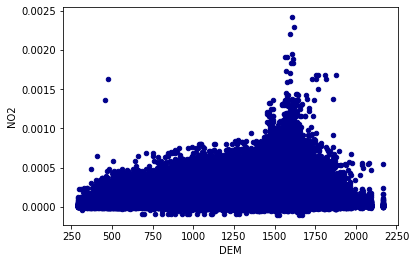

In [58]:
ax1 = train_df.plot.scatter(x='DEM', y='NO2', c='DarkBlue')

Association of NO2 with lon:

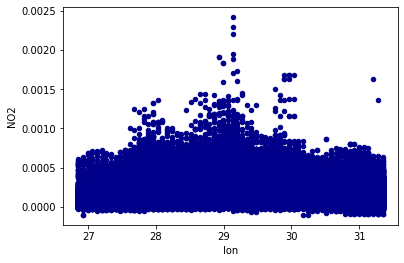

In [59]:
ax2 = train_df.plot.scatter(x='lon', y='NO2', c='DarkBlue')

Association of NO2 with lat:

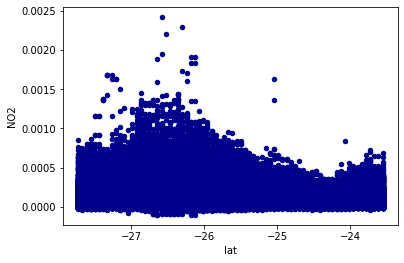

In [60]:
ax3 = train_df.plot.scatter(x='lat', y='NO2', c='DarkBlue')

Association of NO2 with hour:

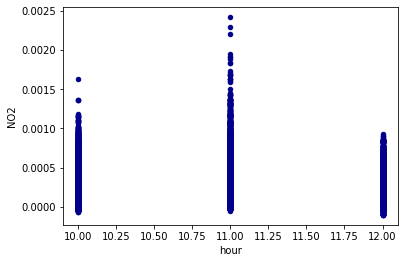

In [61]:
ax4 = train_df.plot.scatter(x='hour', y='NO2', c='DarkBlue')

Association of NO2 with date:

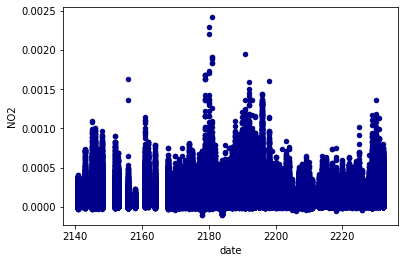

In [62]:
ax5 = train_df.plot.scatter(x='date', y='NO2', c='DarkBlue')

Association of NO2 with relative_humidity:

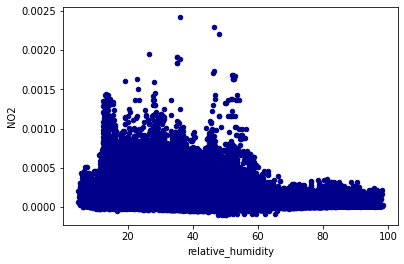

In [64]:
ax6 = train_df.plot.scatter(x='relative_humidity', y='NO2', c='DarkBlue')

Association of NO2 with specific_rain_water_content:

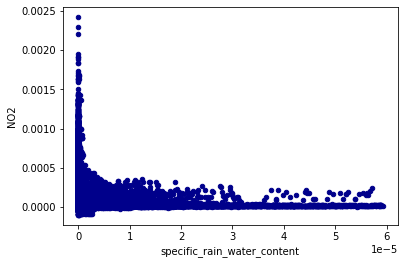

In [65]:
ax7 = train_df.plot.scatter(x='specific_rain_water_content', y='NO2', c='DarkBlue')

Association of NO2 with wind_u:

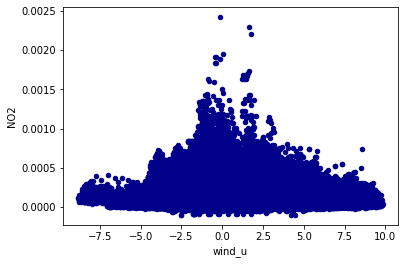

In [66]:
ax8 = train_df.plot.scatter(x='wind_u', y='NO2', c='DarkBlue')

Association of NO2 with wind_v:

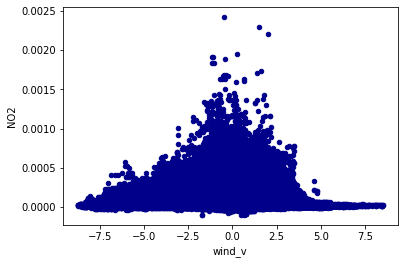

In [67]:
ax9 = train_df.plot.scatter(x='wind_v', y='NO2', c='DarkBlue')

In [26]:
train_df

,lon,lat,NO2,date,hour,datehour_x,relative_humidity,datehour_y,specific_rain_water_content,datehour_x.1,wind_u,datehour_y.1,wind_v,datehour,DEM
0,26.850251,-24.872063,-4.947097e-08,2141.0,10.0,214110,61.785375,214110,0.0,214110,0.940949,214110,0.151119,214110,1228.28080
1,26.850251,-24.872063,-7.892779e-06,2141.0,12.0,214112,37.862161,214112,0.0,214112,2.465065,214112,-0.079335,214112,1228.28080
2,26.850251,-24.872063,1.724746e-05,2143.0,11.0,214311,32.675694,214311,0.0,214311,0.919201,214311,-0.718175,214311,1228.28080
3,26.850251,-24.872063,4.811389e-06,2146.0,12.0,214612,39.504549,214612,0.0,214612,0.516298,214612,0.168391,214612,1228.28080
4,26.850251,-24.872063,3.154637e-05,2148.0,11.0,214811,21.525312,214811,0.0,214811,-1.235898,214811,1.103508,214811,1228.28080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413705,26.919419,-23.900281,1.604731e-05,2221.0,10.0,222110,33.347773,222110,0.0,222110,-1.182237,222110,-3.016625,222110,865.39264
413706,26.919419,-23.900281,2.576492e-05,2227.0,11.0,222711,20.591429,222711,0.0,222711,1.349910,222711,-1.313755,222711,865.39264
413707,26.919419,-23.900281,2.234441e-04,2229.0,11.0,222911,34.526971,222911,0.0,222911,-1.360872,222911,-1.806019,222911,865.39264
413708,26.919419,-23.900281,1.898115e-05,2232.0,12.0,223212,14.935134,223212,0.0,223212,-3.353719,223212,-3.191397,223212,865.39264


Rank correlation between predictors

In [69]:
# calculate the correlation matrix
corr = train_df.drop(['date','datehour','datehour_x','datehour_y','datehour_x.1','datehour_y.1'], axis=1).corr(method='spearman')
round(corr, 2)

,lon,lat,NO2,hour,relative_humidity,specific_rain_water_content,wind_u,wind_v,DEM
lon,1.00,0.00,-0.02,-0.13,0.19,0.14,-0.12,0.13,-0.13
lat,0.00,1.00,-0.32,-0.04,0.12,-0.03,-0.32,-0.02,-0.61
NO2,-0.02,-0.32,1.00,-0.00,-0.23,-0.06,0.11,0.01,0.29
hour,-0.13,-0.04,-0.00,1.00,-0.24,-0.03,0.04,-0.01,0.04
relative_humidity,0.19,0.12,-0.23,-0.24,1.00,0.42,-0.44,-0.02,-0.18
specific_rain_water_content,0.14,-0.03,-0.06,-0.03,0.42,1.00,-0.17,0.02,0.01
wind_u,-0.12,-0.32,0.11,0.04,-0.44,-0.17,1.00,-0.16,0.33
wind_v,0.13,-0.02,0.01,-0.01,-0.02,0.02,-0.16,1.00,-0.01
DEM,-0.13,-0.61,0.29,0.04,-0.18,0.01,0.33,-0.01,1.00


## Modelling

Very simple RF model as a starting point. WARNING! MODELS STILL NEED TO BE TUNED!!

In [27]:
# X and Y parts
train_X = np.array(train_df.drop(['date','datehour','datehour_x','datehour_y','datehour_x.1','datehour_y.1','NO2'], axis=1))
train_y = np.array(train_df['NO2'])

In [28]:
# Random Forest Regression.
rf = RandomForestRegressor(n_estimators = 100) # Let's make it quick for now
# Train the model on training data
rf.fit(train_X, train_y)
pred_y = rf.predict(train_X)

In [72]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(train_df.drop(['date','datehour','datehour_x','datehour_y','datehour_x.1','datehour_y.1','NO2'], axis=1).columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: lat                  Importance: 0.22
Variable: lon                  Importance: 0.2
Variable: wind_u               Importance: 0.19
Variable: relative_humidity    Importance: 0.16
Variable: wind_v               Importance: 0.15
Variable: hour                 Importance: 0.04
Variable: DEM                  Importance: 0.04
Variable: specific_rain_water_content Importance: 0.0


Resubsitution error:

Resubstitution MAE: 0.0
Resubstitution RMSE: 0.0
Resubstitution R2: 0.987


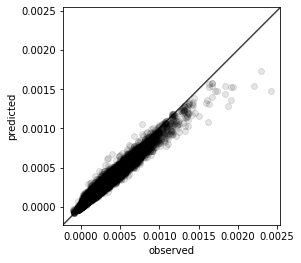

In [73]:
# Resubstitution error
print('Resubstitution MAE:', round(metrics.mean_absolute_error(train_y, pred_y), 2))
print('Resubstitution RMSE:', round(np.sqrt(metrics.mean_squared_error(train_y, pred_y)), 2))
print('Resubstitution R2:', round(metrics.r2_score(train_y, pred_y), 3))

fig, ax = plt.subplots()
ax.scatter(train_y, pred_y, color='black', alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()

Cross-validated error:


In [219]:
# Cross-validated error (each daytime in a separate fold to emulate a new observation)
groups = np.array(train_df['datehour'])
group_kfold = GroupKFold(n_splits=10)
group_kfold.get_n_splits(train_X, train_y, groups)

alltest_CV = np.empty((0,1), float)
allpreds_CV = np.empty((0,1), float)
allindx_CV = np.empty((0,1), float)

MAE_CV=[]
RMSE_CV=[]
R2_CV=[]
for train_index, test_index in group_kfold.split(train_X, train_y, groups):
    train_X_CV, test_X_CV = train_X[train_index], train_X[test_index]
    train_y_CV, test_y_CV = train_y[train_index], train_y[test_index]
    rf.fit(train_X_CV, train_y_CV)
    pred_y_CV = rf.predict(test_X_CV)
    alltest_CV = np.append(alltest_CV, test_y_CV)
    allpreds_CV = np.append(allpreds_CV, pred_y_CV)
    allindx_CV =  np.append(allindx_CV, train_index)
    MAE_CV.append(round(metrics.mean_absolute_error(test_y_CV, pred_y_CV), 2))
    RMSE_CV.append(round(np.sqrt(metrics.mean_squared_error(test_y_CV, pred_y_CV)), 2))
    R2_CV.append(round(metrics.r2_score(test_y_CV, pred_y_CV), 3))

CV MAE: 0.0
CV RMSE: 0.0
CV R2: 0.32


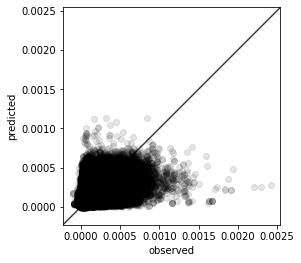

In [47]:
# Metrics
print('CV MAE:', round(statistics.mean(MAE_CV), 2))
print('CV RMSE:', round(statistics.mean(RMSE_CV), 2))
print('CV R2:', round(statistics.mean(R2_CV), 2))

fig, ax = plt.subplots()
ax.scatter(alltest_CV, allpreds_CV, color='black', alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()